In [8]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL

In [97]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN64 = Path('train64/')
TRAIN128 = Path('train128/')
TRAIN256 = Path('train256/')
TEST256 = Path('test256/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
train_names = list(seg.Id.values)

In [ ]:
def rgba_open2(fname, path=PATH, sz=128):
    '''open RGBA image from 1 4-channel image.
    return: numpy array [4, sz, sz]'''
    flags = cv2.IMREAD_UNCHANGED
    rgba = cv2.imread(str(path/(fname+ '.png')),flags)/255
    return rgba #np.rollaxis(rgba, 2,0)

In [16]:
def open_image4d(fn:PathOrStr)->Image:
    "Return `Image` object created from image in file `fn`."
    x = PIL.Image.open(fn)
    return Image(pil2tensor(x).float().div_(255))

In [17]:
fname = train_names[0] + '.png'

In [18]:
im = open_image4(TRAIN64/fname)

In [22]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    
    def _get_x(self,i): return open_image4d(self.x[i])

In [67]:
seg.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [68]:
from fastai.data_block import _df_to_fns_labels
fnames, labels = _df_to_fns_labels(seg, suffix='.png', label_delim=' ', fn_col=0, label_col=1)

In [69]:
seg.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18]


In [29]:
classes = uniqueify(np.concatenate(labels))

In [31]:
train = Image4C_ds(fnames, labels, classes)

In [ ]:
ImageDataBunch.from_df()

In [42]:
train, val = Image4C_ds.from_folder(PATH, TRAIN64, fnames, labels, valid_pct=0.2, classes=classes)

In [49]:
train_dl = DataLoader(train, batch_size=64)
val_dl = DataLoader(val, batch_size=64)

In [50]:
db = ImageDataBunch(train_dl, val_dl)

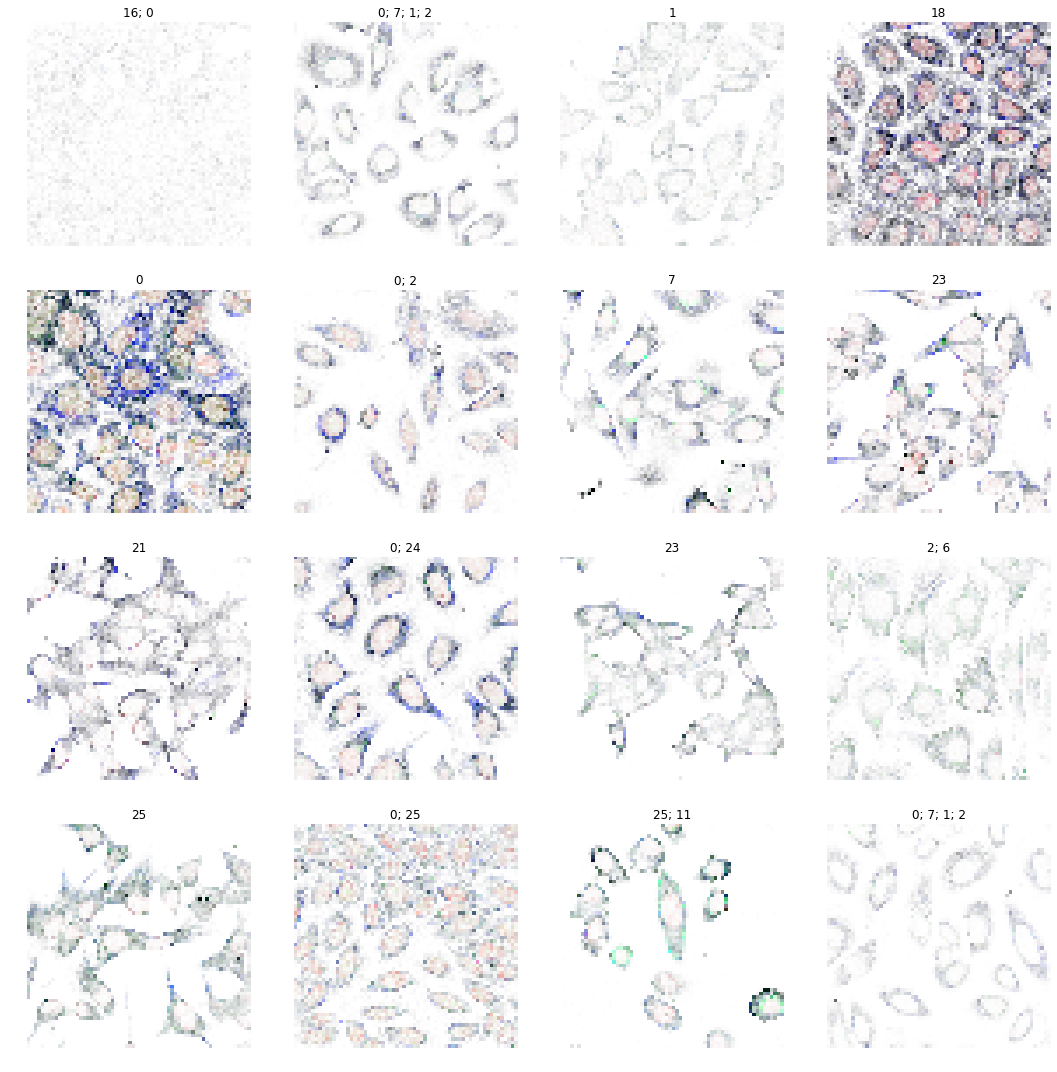

In [51]:
db.show_batch(rows=4, figsize=(15,15))

In [92]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
db.transform(tfms, 64)

DatasetTfm(Image4C_ds of len 24895)

In [98]:
data64 = (ImageFileList.from_folder(PATH)
        .label_from_df(seg, sep=' ', folder=TRAIN64, suffix='.png')  
        .random_split_by_pct(0.2)
        .datasets(Image4C_ds)  
        .transform(tfms)             
        .databunch()
        .normalize(imagenet_stats))

In [73]:
data64

In [84]:
from fastai.vision.models.wrn import *

In [88]:
def _bn(ni, init_zero=False):
    "Batchnorm layer with 0 initialization"
    m = nn.BatchNorm2d(ni)
    m.weight.data.fill_(0 if init_zero else 1)
    m.bias.data.zero_()
    return m

def bn_relu_conv(ni, nf, ks, stride, init_zero=False):
    bn_initzero = _bn(ni, init_zero=init_zero)
    return nn.Sequential(bn_initzero, nn.ReLU(inplace=True), conv2d(ni, nf, ks, stride))

class BasicBlock(nn.Module):
    def __init__(self, ni, nf, stride, drop_p=0.0):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv2d(ni, nf, 3, stride)
        self.conv2 = bn_relu_conv(nf, nf, 3, 1)
        self.drop = nn.Dropout(drop_p, inplace=True) if drop_p else None
        self.shortcut = conv2d(ni, nf, 1, stride) if ni != nf else noop

    def forward(self, x):
        x2 = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x2)
        x = self.conv1(x2)
        if self.drop: x = self.drop(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

def _make_group(N, ni, nf, block, stride, drop_p):
    return [block(ni if i == 0 else nf, nf, stride if i == 0 else 1, drop_p) for i in range(N)]

class WideResNet4(nn.Module):
    def __init__(self, num_groups:int, N:int, num_classes:int, k:int=1, drop_p:float=0.0, start_nf:int=16):
        super().__init__()
        n_channels = [start_nf]
        for i in range(num_groups): n_channels.append(start_nf*(2**i)*k)

        layers = [conv2d(4, n_channels[0], 3, 1)]  # conv1
        for i in range(num_groups):
            layers += _make_group(N, n_channels[i], n_channels[i+1], BasicBlock, (1 if i==0 else 2), drop_p)

        layers += [nn.BatchNorm2d(n_channels[3]), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
                   Flatten(), nn.Linear(n_channels[3], num_classes)]
        self.features = nn.Sequential(*layers)

    def forward(self, x): return self.features(x)


def wrn_22_4(): return WideResNet4(num_groups=3, N=3, num_classes=10, k=6, drop_p=0.)

In [89]:
def f1(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, beta:float=1, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>0.5).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

In [90]:
learn = Learner(data64, wrn_22_4(), metrics=[accuracy_thresh, f1])

RuntimeError: CUDA error: out of memory